# ĐỌC DỮ LIỆU & IMPORT THƯ VIỆN

Dữ liệu được đọc từ file CSV, gồm nội dung email và nhãn spam/ham tương ứng.


In [53]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns # Import seaborn for heatmap

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report # Add classification_report here
)

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Load dữ liệu

In [24]:
# Đọc dữ liệu
df = pd.read_csv("spam_and_ham_classification.csv")
print("Đọc dữ liệu thành công!")

Đọc dữ liệu thành công!


Dữ liệu gốc

In [25]:
df.head()

,label,text
0,ham,into the kingdom of god and those that are ent...
1,spam,there was flow at hpl meter 1505 on april firs...
2,ham,take a look at this one campaign for bvyhprice...
3,spam,somu wrote actually thats what i was looking f...
4,spam,fathi boudra wrote i fixed the issue in the sv...


#KHÁM PHÁ DỮ LIỆU (EDA)



Mục đích:

-Hiểu dữ liệu

-Kiểm tra mất cân bằng

-Phục vụ vẽ biểu đồ

Số lượng email mỗi loai

In [9]:
#Số lượng email mỗi loại (Spam / Ham)
df['label'].value_counts()

,count
label,
ham,5294
spam,4695


Phân bố nhãn

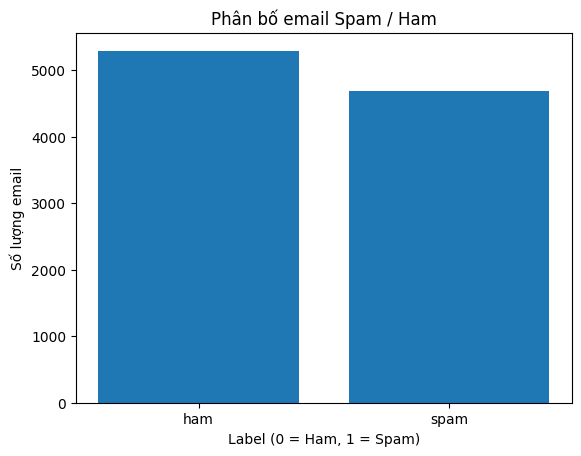

In [8]:
label_counts = df["label"].value_counts()
plt.figure()
plt.bar(label_counts.index.astype(str), label_counts.values)
plt.xlabel("Label (0 = Ham, 1 = Spam)")
plt.ylabel("Số lượng email")
plt.title("Phân bố email Spam / Ham")
plt.show()


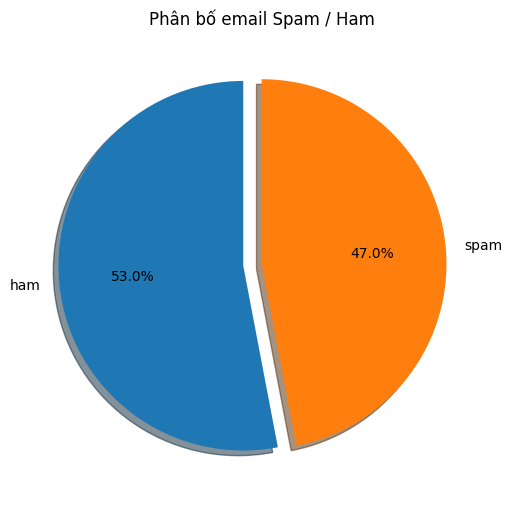

In [19]:
import matplotlib.pyplot as plt
labels = label_counts.index.astype(str)
sizes = label_counts.values
max_index = sizes.argmax()
explode = [0.1 if i == max_index else 0 for i in range(len(sizes))]

plt.figure(figsize=(6,6))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    explode=explode,
    shadow=True
)
plt.title("Phân bố email Spam / Ham")
plt.show()

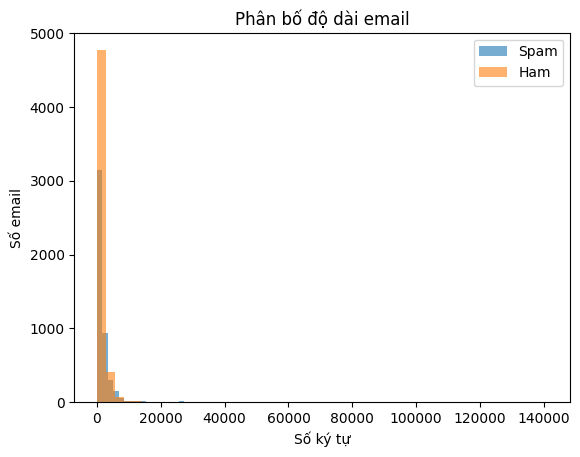

In [10]:
df['length'] = df['text'].apply(len)
plt.hist(df[df['label']=='spam']['length'], bins=50, alpha=0.6, label='Spam')
plt.hist(df[df['label']=='ham']['length'], bins=50, alpha=0.6, label='Ham')
plt.legend()
plt.title("Phân bố độ dài email")
plt.xlabel("Số ký tự")
plt.ylabel("Số email")
plt.show()

2.2 ,Độ dài email

* Biểu đồ thể hiện điều gì?

-Trục X: số ký tự trong email

-Trục Y: số lượng email

Hai màu:

-Spam

-Ham

* Phân tích sâu
-Hình dạng phân bố

Cả spam và ham:

+)Lệch phải (right-skewed)

+)Nhiều email ngắn

+)Ít email rất dài

So sánh spam và ham

+)Spam:

Phân bố trải rộng hơn

Có nhiều email rất dài

+)Ham:

Tập trung ở vùng ngắn

* Điều này phản ánh:

Spam thường:

Quảng cáo

Nội dung lặp

Thông tin thừa

In [26]:
print(df.describe())
# Số lượng giá trị duy nhất cho mỗi cột
print(df.nunique())
# Kiểm tra giá trị thiếu
print(df.isnull().sum())

       label                                               text
count   9989                                               9989
unique     2                                               9989
top      ham  anatrim escapenumber the newest and most attra...
freq    5294                                                  1
label       2
text     9989
dtype: int64
label    0
text     0
dtype: int64


Kiểm gia giá trị thiếu

In [28]:
print(df.isnull().sum().sum())

0


Tiền xử lý dữ liệu

Chuẩn hóa văn bản (Text Cleaning)

Chuyển về chữ thường.

Loại bỏ ký tự đặc biệt, số, dấu câu.

Loại bỏ khoảng trắng thừa.

Loại bỏ stopwords (từ phổ biến không mang ý nghĩa).

Stemming / Lemmatization: đưa từ về dạng gốc.

In [30]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'http\S+|www\S+', ' ', text)
    text = re.sub(r'\S+@\S+', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]

    return " ".join(tokens)

df["final_text"] = df["text"].apply(preprocess_text)

Dữ liệu sau khi tiền xử lý

In [31]:
print(df[['text','final_text']].head(5))

                                                text  \
0  into the kingdom of god and those that are ent...   
1  there was flow at hpl meter 1505 on april firs...   
2  take a look at this one campaign for bvyhprice...   
3  somu wrote actually thats what i was looking f...   
4  fathi boudra wrote i fixed the issue in the sv...   

                                          final_text  
0  kingdom god entering lord pardon escapenumber ...  
1  flow hpl meter april first deal ticket deal ti...  
2  take look one campaign bvyhprice escapenumber ...  
3  somu wrote actually thats looking l r user ent...  
4  fathi boudra wrote fixed issue svn repo rev es...  


#PHÂN TÍCH TỪ VỰNG (TEXT ANALYSIS)



* Biểu đồ thể hiện điều gì?

Mỗi từ:

Xuất hiện càng nhiều → càng to

Chỉ lấy email spam

* Phân tích sâu

-Ngôn ngữ spam có tính lặp

Nhiều từ:

  +)Quảng cáo

  +)Kêu gọi hành động

  +)Tài chính, khuyến mãi

-Vai trò trong pipeline ML:

Giải thích tại sao:

  +)Naive Bayes hiệu quả

  +)TF-IDF cần thiết

Lý do:

  +)Spam dùng từ khóa cố định

  +)Mô hình dễ học xác suất

* Hạn chế

-WordCloud:

  Không loại stopwords

  Không phản ánh mức độ phân biệt

=> Do đó cần TF-IDF

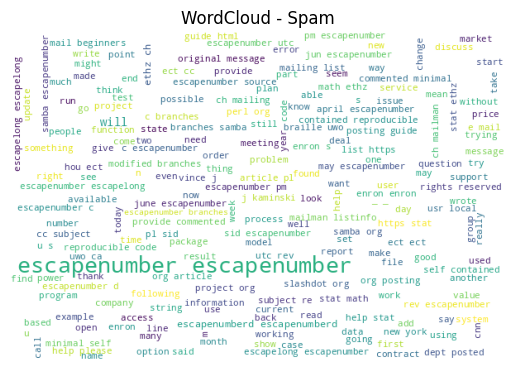

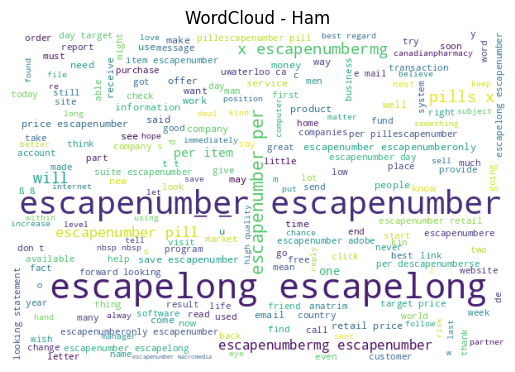

In [32]:
spam_text = " ".join(df[df['label']=='spam']['text'])
ham_text  = " ".join(df[df['label']=='ham']['text'])
wc = WordCloud(width=600, height=400, background_color='white')
plt.imshow(wc.generate(spam_text))
plt.title("WordCloud - Spam")
plt.axis('off')
plt.show()

plt.imshow(wc.generate(ham_text))
plt.title("WordCloud - Ham")
plt.axis('off')
plt.show()

Top các từ phố biến trong dataset

In [35]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
def get_top_words(texts, top_n=20):
    # Đã tiền xử lý stopwords trong 'final_text', nên không cần loại bỏ lại
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(texts)
    word_counts = X.toarray().sum(axis=0)
    word_freq = dict(zip(vectorizer.get_feature_names_out(), word_counts))
    top_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return top_words
# Top từ toàn bộ dataset
top_all = get_top_words(df['final_text']) # Sử dụng 'final_text'
print("Top từ phổ biến toàn bộ dataset:")
for word, count in top_all:
    print(f"{word}: {count}")
# Top từ trong Ham
top_ham = get_top_words(df[df['label']=='ham']['final_text']) # Sửa điều kiện lọc và sử dụng 'final_text'
print("\nTop từ phổ biến trong Ham:")
for word, count in top_ham:
    print(f"{word}: {count}")
# Top từ trong Spam
top_spam = get_top_words(df[df['label']=='spam']['final_text']) # Sửa điều kiện lọc và sử dụng 'final_text'
print("\nTop từ phổ biến trong Spam:")
for word, count in top_spam:
    print(f"{word}: {count}")

Top từ phổ biến toàn bộ dataset:
escapenumber: 135570
escapelong: 24679
http: 9861
com: 8904
enron: 5723
org: 5113
please: 4716
www: 4573
new: 4477
help: 4457
one: 4448
company: 4316
list: 4303
may: 4197
ect: 4111
time: 4036
would: 3966
per: 3843
price: 3835
get: 3629

Top từ phổ biến trong Ham:
escapenumber: 42584
escapelong: 20978
com: 4057
http: 3453
per: 3332
pill: 3133
price: 2941
company: 2606
escapenumbermg: 2574
one: 2188
item: 1882
product: 1817
may: 1797
time: 1694
save: 1664
money: 1556
email: 1536
please: 1517
get: 1511
new: 1491

Top từ phổ biến trong Spam:
escapenumber: 92986
http: 6408
enron: 5723
org: 4988
com: 4847
ect: 4085
help: 3885
list: 3776
escapelong: 3701
samba: 3591
www: 3304
please: 3199
new: 2986
would: 2948
source: 2887
escapenumberd: 2697
stat: 2488
ch: 2466
may: 2400
ethz: 2396


Trực quan hóa

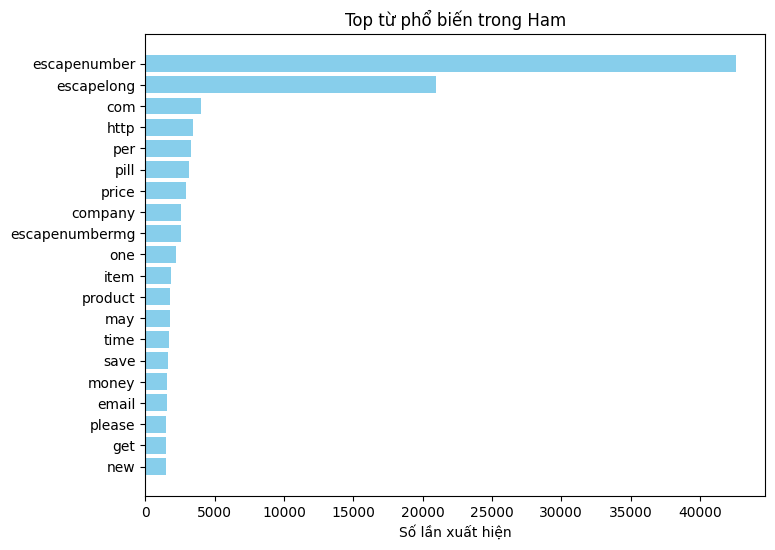

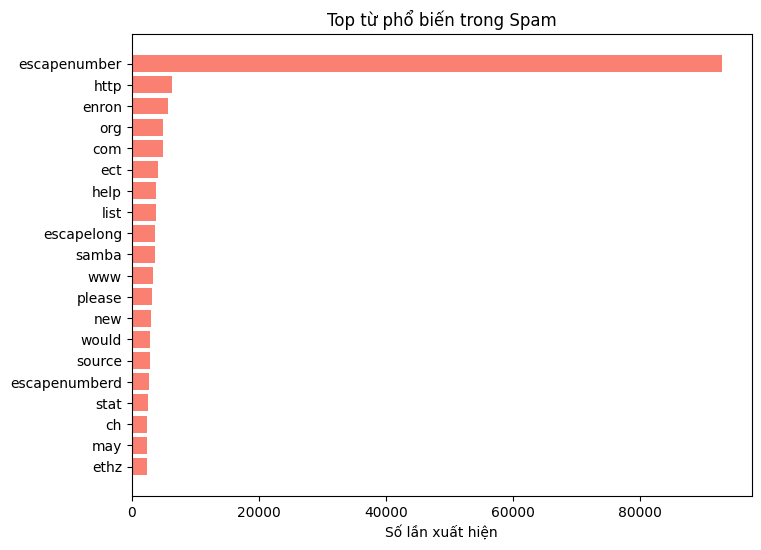

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
def get_top_words(texts, top_n=20):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(texts)
    word_counts = X.toarray().sum(axis=0)
    word_freq = dict(zip(vectorizer.get_feature_names_out(), word_counts))
    top_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return top_words
top_ham = get_top_words(df[df['label']=='ham']['final_text'])
top_spam = get_top_words(df[df['label']=='spam']['final_text'])
words_ham, counts_ham = zip(*top_ham)
words_spam, counts_spam = zip(*top_spam)
plt.figure(figsize=(8,6))
plt.barh(words_ham, counts_ham, color='skyblue')
plt.xlabel("Số lần xuất hiện")
plt.title("Top từ phổ biến trong Ham")
plt.gca().invert_yaxis()
plt.show()
plt.figure(figsize=(8,6))
plt.barh(words_spam, counts_spam, color='salmon')
plt.xlabel("Số lần xuất hiện")
plt.title("Top từ phổ biến trong Spam")
plt.gca().invert_yaxis()
plt.show()

# Huấn luyện và kiểm tra mô hình cho 3 thuật toán

CHIA TRAIN / VAL / TEST (70/15/15)

In [33]:
X = df["final_text"]
y = df["label"]
# 70% train, 30% tạm
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)
# 15% val, 15% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

Tạo TF-IDF vectorizer tối ưu

TF-IDF (1,2)-GRAM

stop_words='english' → bỏ từ phổ biến, giảm noise.

ngram_range=(1,2) → dùng unigram + bigram, bắt cụm từ đặc trưng.

min_df=2 → bỏ từ quá hiếm.

max_df=0.8 → bỏ từ quá phổ biến.

sublinear_tf=True → scale TF theo log, giảm ảnh hưởng từ xuất hiện nhiều.

In [39]:
# 2. Khởi tạo TF-IDF vectorizer
tfidf = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1,2),
    min_df=2,
    max_df=0.8,
    sublinear_tf=True
)

it trên tập huấn luyện (train) và transform trên validation/test

In [40]:
# 1. Fit TF-IDF trên tập train
X_train_tfidf = tfidf.fit_transform(X_train)

# 2. Transform tập validation và test
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

TRỰC QUAN HÓA ĐẶC TRƯNG TF-IDF

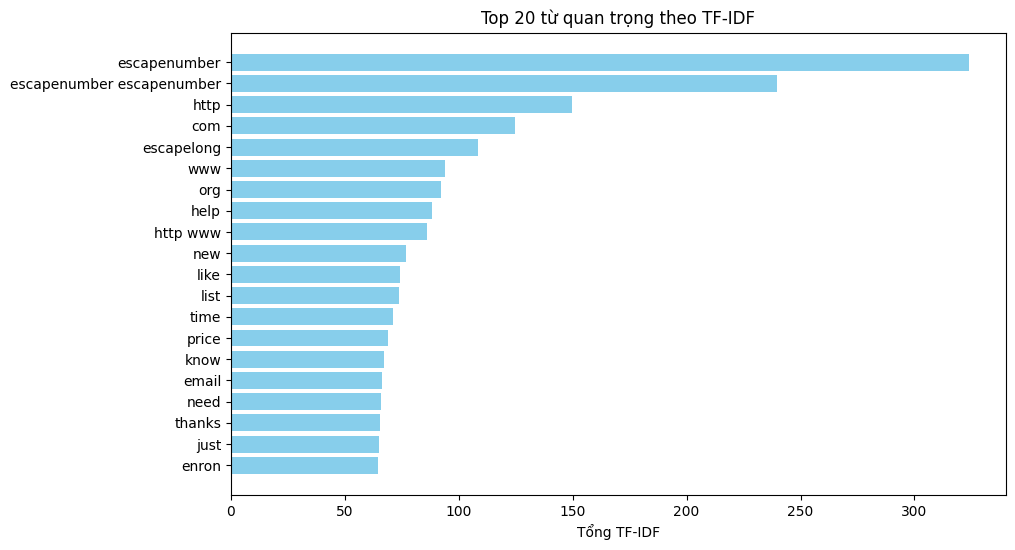

In [50]:
# Fit TF-IDF trên toàn bộ dữ liệu (chỉ để trực quan, không dùng huấn luyện)
X_tfidf = tfidf.fit_transform(df['text'])

# 2. Lấy feature names và tổng trọng số TF-IDF
features = tfidf.get_feature_names_out()
tfidf_sums = X_tfidf.sum(axis=0).A1  # tổng TF-IDF mỗi từ trên toàn bộ dataset
# 3. Tạo DataFrame và sắp xếp
tfidf_df = pd.DataFrame({'word': features, 'tfidf': tfidf_sums})
tfidf_df = tfidf_df.sort_values(by='tfidf', ascending=False).head(20)  # top 20 từ

plt.figure(figsize=(10,6))
plt.barh(tfidf_df['word'][::-1], tfidf_df['tfidf'][::-1], color='skyblue')
plt.xlabel("Tổng TF-IDF")
plt.title("Top 20 từ quan trọng theo TF-IDF")
plt.show()

Khởi tạo mô hinh

In [51]:
# Khởi tạo mô hình
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear SVM": LinearSVC()
}

# Nếu muốn kiểm tra
for name, model in models.items():
    print(f"Đã khởi tạo mô hình: {name}")

Đã khởi tạo mô hình: Naive Bayes
Đã khởi tạo mô hình: Logistic Regression
Đã khởi tạo mô hình: Linear SVM


HÀM HUẤN LUYỆN & ĐÁNH GIÁ


=== Naive Bayes ===
Validation Metrics:
              precision    recall  f1-score   support

         ham     0.9831    0.9547    0.9687       794
        spam     0.9505    0.9815    0.9658       704

    accuracy                         0.9673      1498
   macro avg     0.9668    0.9681    0.9672      1498
weighted avg     0.9678    0.9673    0.9673      1498

Test Metrics:
              precision    recall  f1-score   support

         ham     0.9948    0.9635    0.9789       794
        spam     0.9603    0.9943    0.9770       705

    accuracy                         0.9780      1499
   macro avg     0.9775    0.9789    0.9779      1499
weighted avg     0.9786    0.9780    0.9780      1499



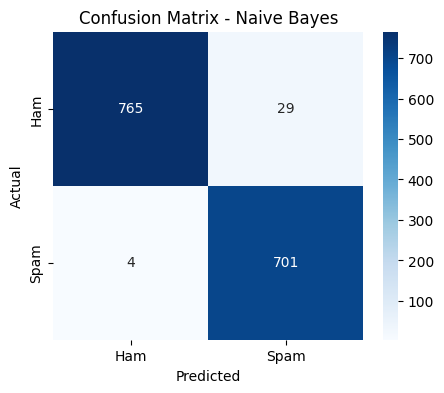


=== Logistic Regression ===
Validation Metrics:
              precision    recall  f1-score   support

         ham     0.9692    0.9899    0.9794       794
        spam     0.9884    0.9645    0.9763       704

    accuracy                         0.9780      1498
   macro avg     0.9788    0.9772    0.9779      1498
weighted avg     0.9782    0.9780    0.9780      1498

Test Metrics:
              precision    recall  f1-score   support

         ham     0.9645    0.9937    0.9789       794
        spam     0.9927    0.9589    0.9755       705

    accuracy                         0.9773      1499
   macro avg     0.9786    0.9763    0.9772      1499
weighted avg     0.9778    0.9773    0.9773      1499



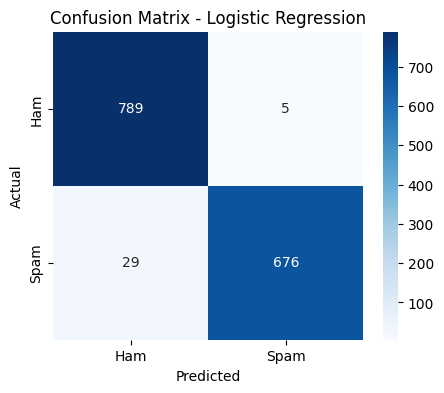


=== Linear SVM ===
Validation Metrics:
              precision    recall  f1-score   support

         ham     0.9862    0.9887    0.9874       794
        spam     0.9872    0.9844    0.9858       704

    accuracy                         0.9866      1498
   macro avg     0.9867    0.9865    0.9866      1498
weighted avg     0.9867    0.9866    0.9866      1498

Test Metrics:
              precision    recall  f1-score   support

         ham     0.9789    0.9950    0.9869       794
        spam     0.9942    0.9759    0.9850       705

    accuracy                         0.9860      1499
   macro avg     0.9866    0.9854    0.9859      1499
weighted avg     0.9861    0.9860    0.9860      1499



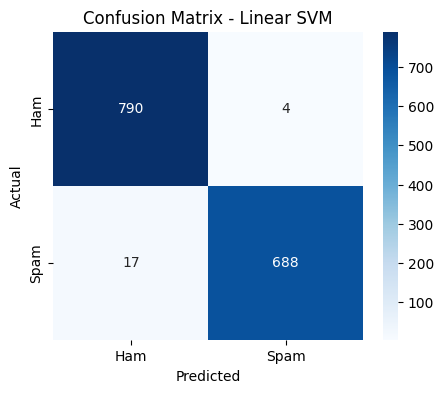

In [54]:
for name, model in models.items():
    # Huấn luyện trên train
    model.fit(X_train_tfidf, y_train)
    # Dự đoán validation và test
    y_val_pred = model.predict(X_val_tfidf)
    y_test_pred = model.predict(X_test_tfidf)

    print(f"\n=== {name} ===")
    print("Validation Metrics:")
    print(classification_report(y_val, y_val_pred, digits=4))
    print("Test Metrics:")
    print(classification_report(y_test, y_test_pred, digits=4))

    # Confusion matrix Test
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Ham","Spam"], yticklabels=["Ham","Spam"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

so sánh các chỉ số (Accuracy, Precision, Recall, F1-score) giữa train, validation và test cho cả ba mô hình

                 Model     Dataset  Accuracy  Precision    Recall  F1-score
0          Naive Bayes       Train  0.987414   0.983082  0.990262  0.986659
1          Naive Bayes  Validation  0.967290   0.950481  0.981534  0.965758
2          Naive Bayes        Test  0.977985   0.960274  0.994326  0.977003
3  Logistic Regression       Train  0.990275   0.998142  0.981132  0.989564
4  Logistic Regression  Validation  0.977971   0.988355  0.964489  0.976276
5  Logistic Regression        Test  0.977318   0.992658  0.958865  0.975469
6           Linear SVM       Train  0.999857   1.000000  0.999696  0.999848
7           Linear SVM  Validation  0.986649   0.987179  0.984375  0.985775
8           Linear SVM        Test  0.985991   0.994220  0.975887  0.984968


/tmp/ipython-input-1156620435.py:43: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=metrics_df_melt, x="Metric", y="Score", hue="Dataset", ci=None, palette="Set2")


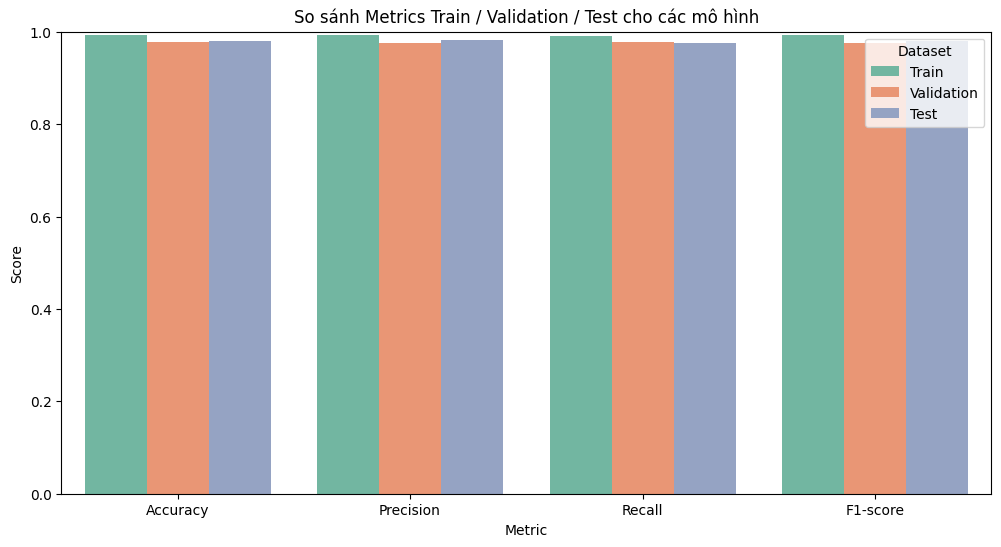

In [56]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Lưu metrics
metrics = {
    "Model": [],
    "Dataset": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-score": []
}

datasets = {
    "Train": (X_train_tfidf, y_train),
    "Validation": (X_val_tfidf, y_val),
    "Test": (X_test_tfidf, y_test)
}

for name, model in models.items():
    for ds_name, (X_ds, y_ds) in datasets.items():
        y_pred = model.predict(X_ds)
        metrics["Model"].append(name)
        metrics["Dataset"].append(ds_name)
        metrics["Accuracy"].append(accuracy_score(y_ds, y_pred))
        metrics["Precision"].append(precision_score(y_ds, y_pred, pos_label='spam')) # Explicitly set pos_label
        metrics["Recall"].append(recall_score(y_ds, y_pred, pos_label='spam'))     # Explicitly set pos_label
        metrics["F1-score"].append(f1_score(y_ds, y_pred, pos_label='spam'))       # Explicitly set pos_label

# Chuyển sang DataFrame
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

# Trực quan hóa
metrics_df_melt = metrics_df.melt(id_vars=["Model","Dataset"],
                                  value_vars=["Accuracy","Precision","Recall","F1-score"],
                                  var_name="Metric", value_name="Score")

plt.figure(figsize=(12,6))
import seaborn as sns
sns.barplot(data=metrics_df_melt, x="Metric", y="Score", hue="Dataset", ci=None, palette="Set2")
plt.title("So sánh Metrics Train / Validation / Test cho các mô hình")
plt.ylim(0,1)
plt.show()

TRỰC QUAN HÓA CONFUSION MATRIX

In [59]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Lưu metrics
metrics = {
    "Model": [],
    "Dataset": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-score": []
}

datasets = {
    "Train": (X_train_tfidf, y_train),
    "Validation": (X_val_tfidf, y_val),
    "Test": (X_test_tfidf, y_test)
}

for name, model in models.items():
    for ds_name, (X_ds, y_ds) in datasets.items():
        y_pred = model.predict(X_ds)
        metrics["Model"].append(name)
        metrics["Dataset"].append(ds_name)
        metrics["Accuracy"].append(accuracy_score(y_ds, y_pred))
        metrics["Precision"].append(precision_score(y_ds, y_pred, pos_label='spam')) # Explicitly set pos_label
        metrics["Recall"].append(recall_score(y_ds, y_pred, pos_label='spam'))     # Explicitly set pos_label
        metrics["F1-score"].append(f1_score(y_ds, y_pred, pos_label='spam'))       # Explicitly set pos_label

# Chuyển sang DataFrame
metrics_df = pd.DataFrame(metrics)

# Hiển thị bảng đẹp
print("\nBảng so sánh Metrics Train / Validation / Test")
print(metrics_df.pivot_table(index="Model", columns="Dataset",
                             values=["Accuracy","Precision","Recall","F1-score"]))


Bảng so sánh Metrics Train / Validation / Test
                     Accuracy                       F1-score            \
Dataset                  Test     Train Validation      Test     Train   
Model                                                                    
Linear SVM           0.985991  0.999857   0.986649  0.984968  0.999848   
Logistic Regression  0.977318  0.990275   0.977971  0.975469  0.989564   
Naive Bayes          0.977985  0.987414   0.967290  0.977003  0.986659   

                               Precision                         Recall  \
Dataset             Validation      Test     Train Validation      Test   
Model                                                                     
Linear SVM            0.985775  0.994220  1.000000   0.987179  0.975887   
Logistic Regression   0.976276  0.992658  0.998142   0.988355  0.958865   
Naive Bayes           0.965758  0.960274  0.983082   0.950481  0.994326   

                                          
Dataset      

SO SÁNH CHỈ SỐ GIỮA CÁC MÔ HÌNH

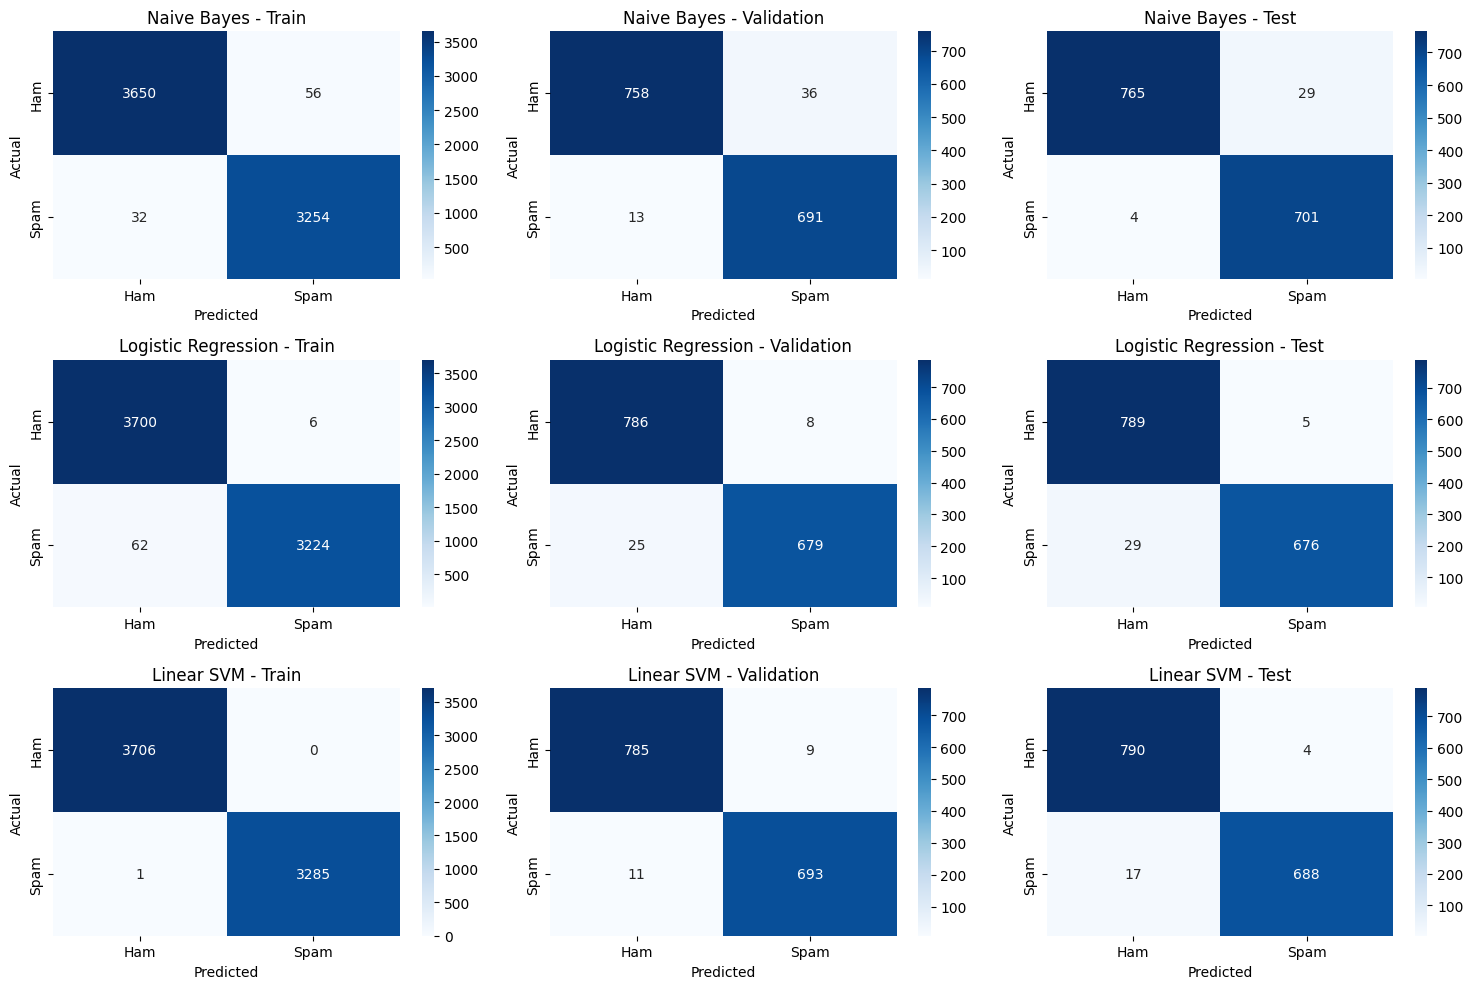

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Tên các tập dữ liệu
datasets = {
    "Train": (X_train_tfidf, y_train),
    "Validation": (X_val_tfidf, y_val),
    "Test": (X_test_tfidf, y_test)
}

# Kích thước figure: 3 mô hình x 3 tập = 9 subplot
fig, axes = plt.subplots(len(models), len(datasets), figsize=(15, 10))

for i, (model_name, model) in enumerate(models.items()):
    for j, (ds_name, (X_ds, y_ds)) in enumerate(datasets.items()):
        y_pred = model.predict(X_ds)
        cm = confusion_matrix(y_ds, y_pred)

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=["Ham","Spam"], yticklabels=["Ham","Spam"],
                    ax=axes[i,j])
        axes[i,j].set_xlabel("Predicted")
        axes[i,j].set_ylabel("Actual")
        axes[i,j].set_title(f"{model_name} - {ds_name}")

plt.tight_layout()
plt.show()


In [63]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

def compare_models(models, X_test, y_test):
    results = {
        "Model": [],
        "Accuracy": [],
        "Precision": [],
        "Recall": [],
        "F1-score": []
    }

    # Tính metrics cho từng mô hình
    for name, model in models.items():
        y_pred = model.predict(X_test)
        results["Model"].append(name)
        results["Accuracy"].append(accuracy_score(y_test, y_pred))
        results["Precision"].append(precision_score(y_test, y_pred, pos_label='spam')) # Chỉ định pos_label='spam'
        results["Recall"].append(recall_score(y_test, y_pred, pos_label='spam'))     # Chỉ định pos_label='spam'
        results["F1-score"].append(f1_score(y_test, y_pred, pos_label='spam'))       # Chỉ định pos_label='spam'

    # Chuyển sang DataFrame
    results_df = pd.DataFrame(results)

    # Hiển thị bảng
    print("\n=== So sánh các mô hình trên tập Test ===")
    print(results_df)

    # Gợi ý mô hình tốt nhất dựa trên F1-score
    best_model = results_df.loc[results_df["F1-score"].idxmax(), "Model"]
    print(f"\nMô hình tốt nhất dựa trên F1-score: {best_model}")

    return results_df

# Sử dụng hàm
metrics_df = compare_models(models, X_test_tfidf, y_test)


=== So sánh các mô hình trên tập Test ===
                 Model  Accuracy  Precision    Recall  F1-score
0          Naive Bayes  0.977985   0.960274  0.994326  0.977003
1  Logistic Regression  0.977318   0.992658  0.958865  0.975469
2           Linear SVM  0.985991   0.994220  0.975887  0.984968

Mô hình tốt nhất dựa trên F1-score: Linear SVM
